# Histogram Density Plots for Phenotypic Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# load trait data
auspak_traits = pd.read_csv('../data/AUSPAK_phenotypes_means_BLUEs.csv')

# keep only BLUE values
auspak_blues = auspak_traits.loc[:, ~auspak_traits.columns.str.contains('_mean')].copy()

# drop the suffix and rename
auspak_blues.columns = auspak_blues.columns.str.replace('_blue', '', regex=False)
auspak_blues = auspak_blues.rename(columns={'SdW_z': 'SdW'})

auspak_blues.head()

,environment,location,year,SampleName,DTF,DTH,PtHt,PcleLng,SdLen,TGW,SdW
0,PAK_2019,PAK,2019,S3H3_batch1,86.37,131.44,72.40,24.20,1.90,2.46,-0.99
1,PAK_2019,PAK,2019,S1F6_batch1,NaN,152.37,NaN,36.22,1.90,2.28,-0.10
2,PAK_2019,PAK,2019,S1C6_batch1,88.87,131.19,NaN,34.10,1.88,2.62,-0.06
3,PAK_2019,PAK,2019,KATRC10,90.62,135.44,NaN,32.45,2.04,2.62,0.38
4,PAK_2019,PAK,2019,S1D11_batch1,92.37,127.69,81.65,31.32,2.08,2.75,-0.05


In [ ]:

def plot_trait_histograms(df, trait_columns=None, figsize=(16, 12), 
                              trait_order=None, bins=25, alpha=0.7):
    """
    Create histogram density plots for each trait, colored by location.
    
    """
    
    # Auto-detect trait columns if not provided
    if trait_columns is None:
        exclude_cols = ['location', 'year', 'SampleName']
        trait_columns = [col for col in df.columns if col not in exclude_cols]
    
    # Trait display names and units
    trait_info = {
        'DTF': ('Days to Flowering', 'days'),
        'DTH': ('Days to Harvest', 'days'), 
        'PtHt': ('Plant Height', 'cm'),
        'PcleLng': ('Panicle Length', 'cm'),
        'SdW': ('Seed Yield', 'z-scaled by environment'),
        'SdLen': ('Seed Length', 'mm'),
        'TGW': ('Thousand Grain Weight', 'grams')
    }
    
    # Location colors: PAK yellow, AUS blue
    location_colors = {'PAK': '#ffb347', 'AUS': '#1f77b4'}
    locations = sorted(df['location'].unique())
    
    # Determine trait order
    if trait_order is not None:
        available_traits = set(trait_columns)
        traits = [t for t in trait_order if t in available_traits]
        traits.extend(sorted(available_traits - set(traits)))
    else:
        traits = sorted(trait_columns)
    
    # Create 4x2 subplot layout
    fig, axes = plt.subplots(4, 2, figsize=figsize, sharey=False)
    axes = axes.flatten()
    
    # Plot each trait
    for i, trait in enumerate(traits):
        ax = axes[i]
        trait_data = df[['location', trait]].dropna()
        
        if not trait_data.empty and trait_data[trait].notna().any():
            # Calculate plotting range with 5% padding
            data_min, data_max = trait_data[trait].min(), trait_data[trait].max()
            data_range = data_max - data_min
            plot_min = data_min - data_range * 0.05
            plot_max = data_max + data_range * 0.05
            
            # Plot histogram and KDE for each location
            for location in locations:
                location_data = trait_data[trait_data['location'] == location][trait]
                
                if len(location_data) > 0:
                    color = location_colors[location]
                    
                    # Histogram
                    ax.hist(location_data, bins=bins, alpha=alpha, color=color,
                           label=location, density=True, edgecolor='black', linewidth=0.5)
                    
                    # KDE curve
                    if len(location_data) > 1:
                        try:
                            kde = scipy_stats.gaussian_kde(location_data)
                            x_range = np.linspace(plot_min, plot_max, 100)
                            ax.plot(x_range, kde(x_range), color=color, 
                                   linewidth=2, linestyle='-')
                        except:
                            pass  # Skip if KDE fails
                    
                    # Mean line
                    ax.axvline(location_data.mean(), color=color, 
                              linestyle='--', linewidth=2, alpha=0.8)
            
            # Get trait name and units
            trait_name, units = trait_info.get(trait, (trait, 'Value'))
            
            # Format subplot
            ax.set_title(trait_name, fontsize=14, fontweight='bold', pad=10)
            ax.set_xlabel(units, fontsize=12)
            ax.set_ylabel('')
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.grid(True, alpha=0.3)
            
            if data_range > 0:
                ax.set_xlim(plot_min, plot_max)
        
        else:
            # No data available
            trait_name = trait_info.get(trait, (trait, 'Value'))[0]
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                   fontsize=18, color='gray', transform=ax.transAxes)
            ax.set_title(trait_name, fontsize=14, fontweight='bold', pad=10)
            ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Hide unused subplots except position 7 (for legend)
    for j in range(len(traits), len(axes)):
        if j != 7:
            axes[j].set_visible(False)
    
    # Add legend to 8th subplot position
    if len(axes) > 7:
        legend_ax = axes[7]
        legend_ax.set_visible(True)
        legend_ax.axis('off')
        
        legend_elements = [
            Patch(facecolor=location_colors['AUS'], alpha=alpha, 
                  edgecolor='black', linewidth=0.5, label='AUS'),
            Patch(facecolor=location_colors['PAK'], alpha=alpha, 
                  edgecolor='black', linewidth=0.5, label='PAK'),
            Line2D([0], [0], color='black', linestyle='--', linewidth=2, 
                   label='Mean values'),
            Line2D([0], [0], color='black', linestyle='-', linewidth=2, 
                   label='Density curves')
        ]
        
        legend_ax.legend(handles=legend_elements, loc='center', fontsize=14,
                        frameon=True, fancybox=True, shadow=True,
                        title='Legend', title_fontsize=16)
    
    plt.tight_layout()
    
    # Add y-axis label for entire figure
    fig.text(0.01, 0.5, 'Density', ha='center', va='center',
             fontsize=14, fontweight='bold', rotation=90)
    
    return fig



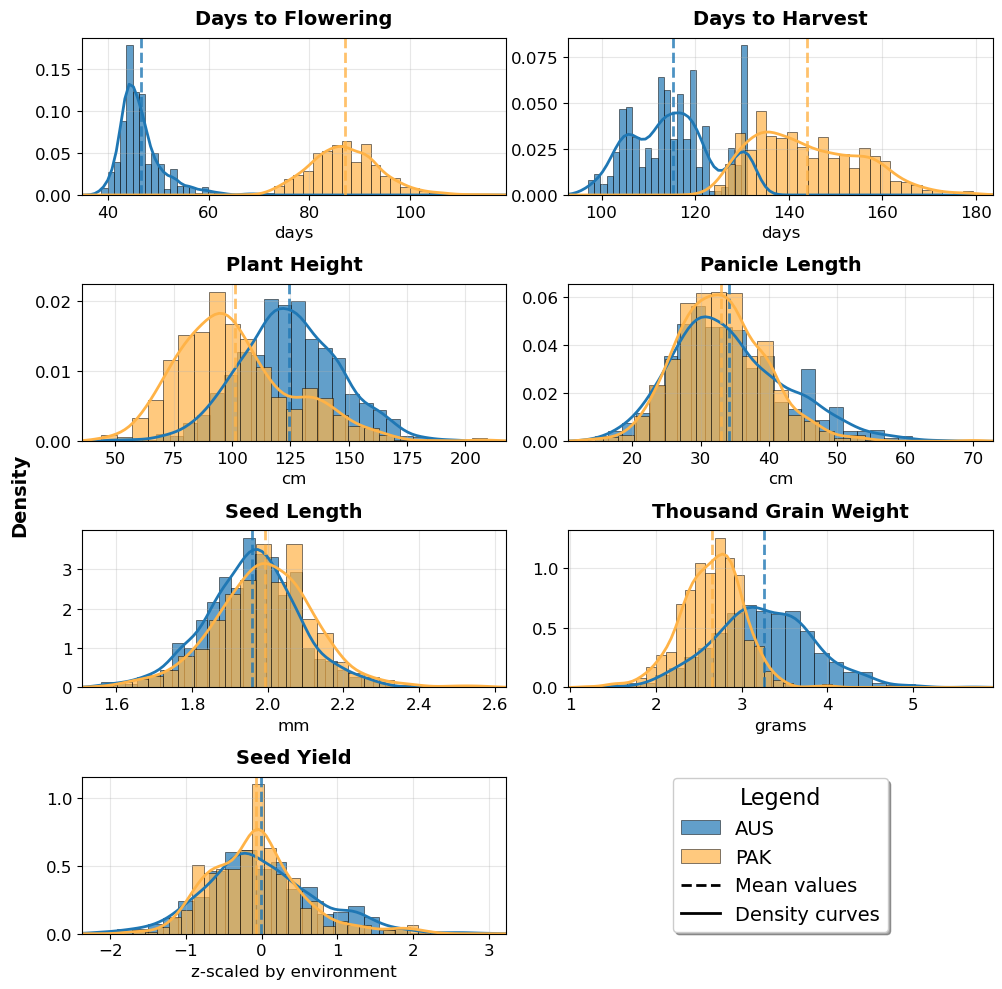

In [5]:
trait_columns = ['PtHt', 'PcleLng', 'TGW', 'SdLen', 'DTF', 'DTH', 'SdW']
trait_order = ['DTF', 'DTH', 'PtHt', 'PcleLng', 'SdLen', 'TGW', 'SdW']

fig = plot_trait_histograms(auspak_blues, 
                                trait_columns=trait_columns,
                                trait_order=trait_order,
                                figsize=(10, 10),
                                bins=25,
                                alpha=0.7)

# fig.savefig('figures_for_manuscript/trait_histograms_by_location.png', 
#             dpi=300, bbox_inches='tight')

plt.show()

# Custom Correlation Plot for Two Locations

Integrated correlation matrix that shows both within-location trait relationships, generalized heritabilities, and cross-location correlations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.patches as patches

In [ ]:
# load trait data
auspak_traits = pd.read_csv('../data/AUSPAK_phenotypes_means_BLUEs.csv')

# keep only BLUE values
auspak_blues = auspak_traits.loc[:, ~auspak_traits.columns.str.contains('_mean')].copy()

# drop the suffix and rename
auspak_blues.columns = auspak_blues.columns.str.replace('_blue', '', regex=False)
auspak_blues = auspak_blues.rename(columns={'SdW_z': 'SdW'})


In [9]:

def plot_triangular_trait_correlations(df, trait_columns=None, location_column='location', 
                                     sample_column='SampleName', figsize=(20, 12),
                                     trait_order=None, significance_level=0.05):
    """
    Create triangular correlation plot with Australia and Pakistan correlations as lower triangles
    Australia is mirrored/flipped so they meet back-to-back with cross-location in the middle
    Trait labels are positioned next to the closest filled box in each triangle
    Diagonal shows heritability values as black text on white background
    Cross-location column uses correlation color scale with AUS/PAK colored borders
    """
    
    # Auto-detect trait columns if not provided
    if trait_columns is None:
        exclude_cols = [location_column, 'year', sample_column]
        trait_columns = [col for col in df.columns if col not in exclude_cols]
    
    # Define trait name mapping for full names
    trait_name_mapping = {
        'DTF': 'Days to Flowering',
        'DTH': 'Days to Harvest', 
        'PtHt': 'Plant Height',
        'PcleLng': 'Panicle Length',
        'SdW': 'Seed Yield',
        'SdLen': 'Seed Length',
        'TGW': 'Thousand Grain Weight'
    }
    
    # Define heritability values for each location (were estimated previously)
    heritability_values = {
        'AUS': {
            'DTF': 0.47,
            'DTH': 0.66,
            'PtHt': 0.67,
            'PcleLng': 0.45,
            'SdLen': 0.74,
            'TGW': 0.56,
            'SdW': 0.35
        },
        'PAK': {
            'DTF': 0.57,
            'DTH': 0.77,
            'PtHt': 0.75,
            'PcleLng': 0.42,
            'SdLen': 0.46,
            'TGW': 0.55,
            'SdW': 0.33
        }
    }
    
    # Use specified trait order if provided
    if trait_order is not None:
        available_traits = set(trait_columns)
        traits = [trait for trait in trait_order if trait in available_traits]
        remaining_traits = sorted(available_traits - set(traits))
        traits.extend(remaining_traits)
    else:
        traits = sorted(trait_columns)
    
    n_traits = len(traits)
    trait_display_names = [trait_name_mapping.get(trait, trait) for trait in traits]
    
    # Calculate averages per location and sample
    avg_data = df.groupby([sample_column, location_column])[trait_columns].mean().reset_index()
    
    # Get data for each location
    aus_data = avg_data[avg_data[location_column] == 'AUS']
    pak_data = avg_data[avg_data[location_column] == 'PAK']
    
    # Calculate correlation matrices
    aus_corr = aus_data[traits].corr()
    pak_corr = pak_data[traits].corr()
    
    # Calculate cross-environment correlations
    cross_corr = []
    cross_pvals = []
    
    # Merge data on sample names to get paired observations
    merged_data = pd.merge(aus_data[[sample_column] + traits], 
                          pak_data[[sample_column] + traits], 
                          on=sample_column, suffixes=('_aus', '_pak'))
    
    for trait in traits:
        trait_aus = f"{trait}_aus"
        trait_pak = f"{trait}_pak"
        
        # Remove NaN values
        valid_data = merged_data[[trait_aus, trait_pak]].dropna()
        
        if len(valid_data) >= 3:
            corr_val, p_val = stats.pearsonr(valid_data[trait_aus], valid_data[trait_pak])
            cross_corr.append(corr_val)
            cross_pvals.append(p_val)
        else:
            cross_corr.append(0)
            cross_pvals.append(1.0)
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Define positions for the triangular layout
    cell_size = 1.0
    
    # Layout: Australia (flipped lower triangle) + blank column + Pakistan (lower triangle)
    # Total width: n_traits + 1 + n_traits = 2*n_traits + 1
    combined_width = 2 * n_traits + 1
    
    # Correlation colormap 
    corr_cmap = plt.cm.PRGn
    corr_vmin, corr_vmax = -1, 1
    
    # Define colors for borders
    aus_color = '#1f77b4'  # Blue for Australia
    pak_color = '#ff7f0e'  # Orange/Yellow for Pakistan
    
    # Plot Australia triangle (lower triangle, but mirrored/flipped)
    for i in range(n_traits):
        for j in range(i + 1):  # Lower triangle indices
            # Position in the left triangle (mirrored: rightmost column of left section)
            # For mirroring: instead of x=j, x=(n_traits-1-j) to flip horizontally
            x = (n_traits - 1) - j
            y = n_traits - 1 - i
            
            if i == j:  # Diagonal - use white background for heritability values
                herit_val = heritability_values['AUS'].get(traits[i], 0.0)
                
                # Create rectangle with white background
                rect = patches.Rectangle((x, y), cell_size, cell_size, 
                                       linewidth=1.5, edgecolor=aus_color,
                                       facecolor='white')
                ax.add_patch(rect)
                
                # Add text annotation for heritability
                ax.text(x + 0.5, y + 0.5, f'{herit_val:.2f}', 
                       ha='center', va='center', fontsize=13, fontweight='bold',
                       color='black')
            else:  # Off-diagonal - use correlation values
                corr_val = aus_corr.iloc[i, j]
                
                # Create rectangle with correlation color scale
                rect = patches.Rectangle((x, y), cell_size, cell_size, 
                                       linewidth=1, edgecolor='white',
                                       facecolor=corr_cmap((corr_val - corr_vmin) / (corr_vmax - corr_vmin)))
                ax.add_patch(rect)
                
                # Check significance for Australia
                aus_pval = calculate_pvalue(aus_data, traits[i], traits[j])
                text = f'{corr_val:.2f}' if aus_pval < significance_level else 'ns'
                ax.text(x + 0.5, y + 0.5, text, 
                       ha='center', va='center', fontsize=13, fontweight='bold')
    
    # Plot Pakistan triangle (normal lower triangle)
    for i in range(n_traits):
        for j in range(i + 1):  # Lower triangle
            # Position in the right triangle (shifted by n_traits + 1 for blank column)
            x = j + n_traits + 1
            y = n_traits - 1 - i
            
            if i == j:  # Diagonal - use white background for heritability values
                herit_val = heritability_values['PAK'].get(traits[i], 0.0)
                
                # Create rectangle with white background and Pakistan colored edge
                rect = patches.Rectangle((x, y), cell_size, cell_size, 
                                       linewidth=1.5, edgecolor=pak_color,
                                       facecolor='white')
                ax.add_patch(rect)
                
                # Add text annotation for heritability
                ax.text(x + 0.5, y + 0.5, f'{herit_val:.2f}', 
                       ha='center', va='center', fontsize=13, fontweight='bold',
                       color='black')
                
            else:  # Off-diagonal - use correlation values
                corr_val = pak_corr.iloc[i, j]
                
                # Create rectangle with correlation color scale
                rect = patches.Rectangle((x, y), cell_size, cell_size, 
                                       linewidth=1, edgecolor='white',
                                       facecolor=corr_cmap((corr_val - corr_vmin) / (corr_vmax - corr_vmin)))
                ax.add_patch(rect)
                
                # Check significance for Pakistan
                pak_pval = calculate_pvalue(pak_data, traits[i], traits[j])
                text = f'{corr_val:.2f}' if pak_pval < significance_level else 'ns'
                ax.text(x + 0.5, y + 0.5, text, 
                       ha='center', va='center', fontsize=13, fontweight='bold')

    # Plot cross-location correlations (middle column)
    for i in range(n_traits):
        corr_val = cross_corr[i]
        p_val = cross_pvals[i]
        
        # Position in the middle column
        x = n_traits 
        y = n_traits - 1 - i

        # Create rectangle for cross-location correlation using correlation color scale
        rect = patches.Rectangle((x, y), cell_size, cell_size, 
                               linewidth=1, edgecolor='white',
                               facecolor=corr_cmap((corr_val - corr_vmin) / (corr_vmax - corr_vmin)))
        ax.add_patch(rect)
        
        # Add colored border lines
        # Left border (AUS color - blue)
        left_border = patches.Rectangle((x - 0.05, y), 0.15, cell_size, # 0.15 is thicker line, and added 0.05 to move bar slightly over
                                      linewidth=0, 
                                      facecolor=aus_color, alpha=0.9)
        ax.add_patch(left_border)
        
        # Right border (PAK color - orange/yellow)
        right_border = patches.Rectangle((x + cell_size - 0.10, y), 0.15, cell_size, # 0.15 is thicker line
                                       linewidth=0, 
                                       facecolor=pak_color, alpha=0.9)
        ax.add_patch(right_border)
        
        # Add text annotation for cross-correlation
        text = f'{corr_val:.2f}' if p_val < significance_level else 'ns'
        ax.text(x + 0.5, y + 0.5, text, 
               ha='center', va='center', fontsize=13, fontweight='bold')
    
    # Add trait labels positioned next to closest filled boxes
    
    # For Australia triangle (mirrored) - labels go to the left of leftmost filled box in each row
    for i in range(n_traits):
        trait_name = trait_display_names[i]
        y_pos = n_traits - 1 - i + 0.5  # Center of the row
        
        # Find leftmost filled box in this row (Australia triangle)
        # In row i, we have boxes from j=0 to j=i (mirrored positions)
        leftmost_box_x = (n_traits - 1) - i  # This is the leftmost box position in mirrored triangle
        
        # Place label to the left of the leftmost box
        label_x = leftmost_box_x - 0.1
        ax.text(label_x, y_pos, trait_name, 
               ha='right', va='center', fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))
    
    # For Pakistan triangle - labels go to the right of rightmost filled box in each row
    for i in range(n_traits):
        trait_name = trait_display_names[i]
        y_pos = n_traits - 1 - i + 0.5  # Center of the row
        
        # Find rightmost filled box in this row (Pakistan triangle)
        # In row i, we have boxes from j=0 to j=i
        rightmost_box_x = i + n_traits + 1  # This is the rightmost box position in Pakistan triangle
        
        # Place label to the right of the rightmost box
        label_x = rightmost_box_x + 1 + 0.1
        ax.text(label_x, y_pos, trait_name, 
               ha='left', va='center', fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8, edgecolor='none'))
    
    # X-axis labels for Australia (bottom, mirrored)
    for j, trait_name in enumerate(trait_display_names):
        # For mirrored Australia: reverse the order
        x_pos = (n_traits - 1) - j + 0.5
        ax.text(x_pos, -0.1, trait_name, 
               ha='right', va='top', fontsize=12, fontweight='bold', rotation=45)
    
    # X-axis labels for Pakistan (bottom)
    for j, trait_name in enumerate(trait_display_names):
        x_pos = j + n_traits + 1 + 0.5
        ax.text(x_pos, -0.1, trait_name, 
               ha='right', va='top', fontsize=12, fontweight='bold', rotation=45)
    
    # Set up the plot with some extra padding for labels
    ax.set_xlim(-3, combined_width + 3)
    ax.set_ylim(-2, n_traits + 1)
    ax.set_aspect('equal')
    
    # Move location labels to the top
    ax.text(n_traits//2, n_traits + 0.3, 'AUSTRALIA', ha='center', va='bottom', 
           fontsize=16, fontweight='bold', color=aus_color)
    ax.text(n_traits + 1 + n_traits//2, n_traits + 0.3, 'PAKISTAN', ha='center', va='bottom', 
           fontsize=16, fontweight='bold', color=pak_color)
    ax.text(n_traits + 0.5, n_traits + 0.3, 'CROSS-LOCATION', ha='center', va='bottom', 
           fontsize=14, fontweight='bold', color='black')
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add correlation colorbar
    sm_corr = plt.cm.ScalarMappable(cmap=corr_cmap, norm=plt.Normalize(vmin=corr_vmin, vmax=corr_vmax))
    sm_corr.set_array([])
    cbar_corr = plt.colorbar(sm_corr, ax=ax, shrink=0.6, aspect=20, pad=0.02)
    cbar_corr.set_label('Correlation Coefficient', fontsize=12, fontweight='bold')
    cbar_corr.ax.tick_params(labelsize=13)

    
    plt.tight_layout()
    
    return fig, merged_data, cross_corr


def calculate_pvalue(data, trait1, trait2):
    """Calculate p-value for correlation between two traits"""
    data1 = data[trait1].dropna()
    data2 = data[trait2].dropna()
    common_idx = data1.index.intersection(data2.index)
    
    if len(common_idx) >= 3:
        _, p_val = stats.pearsonr(data1.loc[common_idx], data2.loc[common_idx])
        return p_val
    else:
        return 1.0

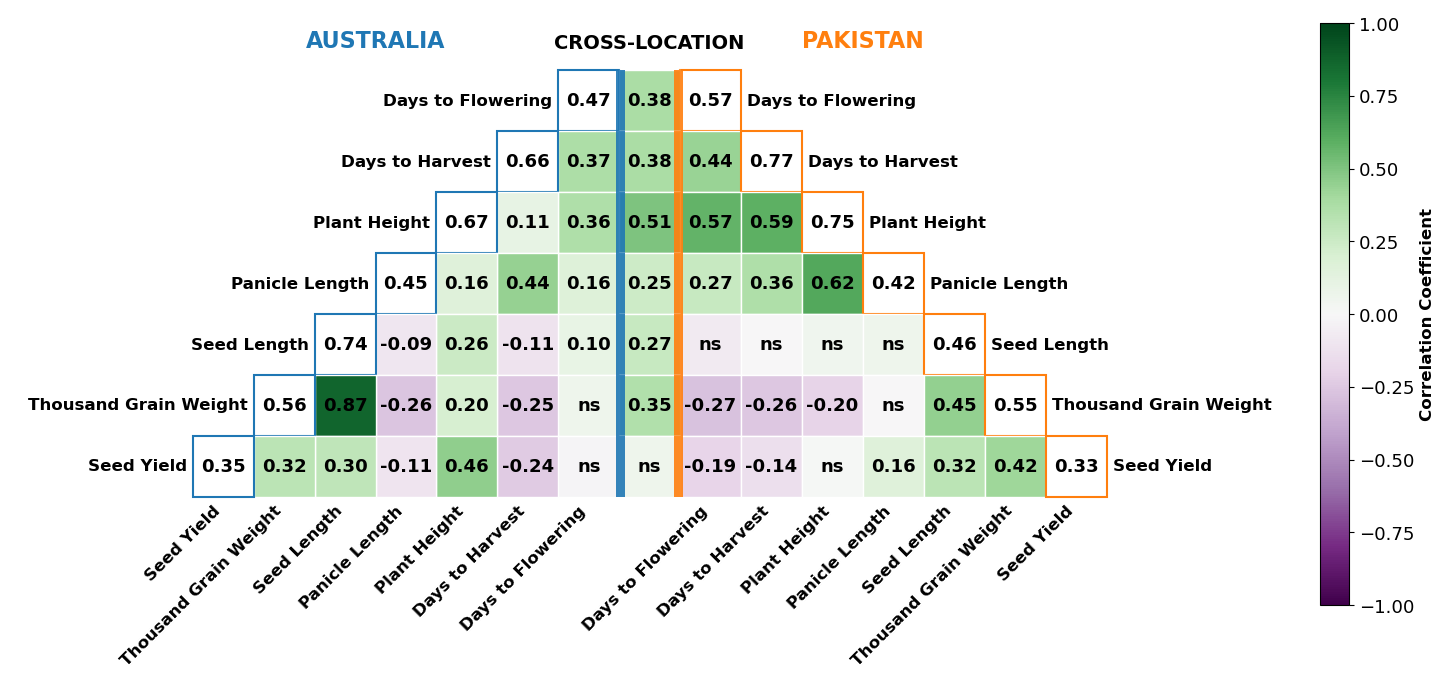

In [ ]:

trait_order = ['DTF', 'DTH', 'PtHt', 'PcleLng', 'SdLen', 'TGW']
trait_columns = ['PtHt', 'PcleLng', 'TGW', 'SdLen', 'DTF', 'DTH', 'SdW']

fig, merged_data, cross_correlations = plot_triangular_trait_correlations(
    auspak_blues, 
    trait_columns=trait_columns,
    location_column='location',
    sample_column='SampleName', 
    trait_order=trait_order,
    figsize=(16, 10),
    significance_level=0.05
)

plt.show()




# Visualize Genomic Prediction Results

In [2]:
GBLUP = pd.read_csv('../data/GBLUP_results.csv')

GBLUP.head()

,iteration,fold,trait,location,pearson,ndcg_at_10,seed,n_test_genotypes
0,1,1,PcleLng_mean,AUS,0.475379,0.670820,1001,103
1,1,1,PcleLng_mean,PAK,0.196981,0.596007,1001,61
2,1,1,SdW_mean,AUS,0.212809,0.691356,1001,108
3,1,1,SdW_mean,PAK,0.007079,0.480608,1001,57
4,1,1,TGW_mean,AUS,0.468303,0.757675,1001,101


In [3]:
ML = pd.read_pickle(
    '../data/LightGBM_results.pkl')
ML.head()

,iteration,fold,trait,location,pearson,ndcg_at_10,seed,n_test_genotypes
0,1,1,PtHt_mean,PAK,0.179992,0.844596,1001,61
1,1,1,PtHt_mean,AUS,0.346024,0.715219,1001,110
2,1,1,PcleLng_mean,PAK,0.133347,0.660533,1001,60
3,1,1,PcleLng_mean,AUS,0.205523,0.614138,1001,101
4,1,1,SdW_z_mean,PAK,-0.076865,0.522117,1001,57


In [4]:
# add model column before merging
GBLUP['model'] = 'GBLUP'
ML['model'] = 'LGBM'

# merge dataframes
auspakgp = pd.concat([GBLUP, ML], ignore_index=True)

# rename trait 'SdW_z_blue' to 'SdW_blue'
auspakgp['trait'] = auspakgp['trait'].replace({'SdW_z_blue': 'SdW_blue'})
# drop 'SdW_mean' in case already present
auspakgp = auspakgp[auspakgp['trait'] != 'SdW_mean']
# rename 'SdW_z_mean' to 'SdW_mean' (so we can identify it consistently)
auspakgp['trait'] = auspakgp['trait'].replace({'SdW_z_mean': 'SdW_mean'})

### load functions

In [5]:
def restructure_dataframe(df):
    """
    Restructure the dataframe to separate trait names from input type (_mean or _blue)
    """
    # Create a copy to avoid modifying original
    df_restructured = df.copy()
    
    # Extract input_type and clean trait names
    df_restructured['input_type'] = df_restructured['trait'].str.extract(r'_([^_]+)$')[0]
    df_restructured['trait'] = df_restructured['trait'].str.replace(r'_(?:mean|blue)$', '', regex=True)
    
    return df_restructured
    
def prepare_metric_data(df, input_type='blue'):
    """
    Prepare data with both pearson and ndcg_10 metrics in long format
    """
    # Filter for specified input_type
    filtered_data = df[df['input_type'] == input_type].copy()
    
    if filtered_data.empty:
        print(f"Warning: No data found for input_type='{input_type}'")
        return pd.DataFrame()
    
    # Check if both metrics exist in the dataframe
    required_metrics = ['pearson', 'ndcg_at_10']
    available_metrics = [metric for metric in required_metrics if metric in filtered_data.columns]
    
    if not available_metrics:
        print("Error: No suitable metrics found in dataframe")
        return pd.DataFrame()
    
    # Define id_vars and keep only those that exist in the dataframe
    id_vars = ['trait', 'location', 'model', 'iteration', 'fold', 'seed', 'n_test_genotypes', 'input_type']
    existing_id_vars = [var for var in id_vars if var in filtered_data.columns]
    
    # Melt the dataframe to have metrics in long format
    melted_data = pd.melt(
        filtered_data,
        id_vars=existing_id_vars,
        value_vars=available_metrics,
        var_name='metric',
        value_name='value'
    )
    
    # Remove rows with NaN values
    melted_data = melted_data.dropna(subset=['value'])
    
    return melted_data


def plot_genomic_prediction_with_metrics(df, figsize=(20, 16), 
                                       trait_order=None, input_type='mean'):
    """
    Create boxplots comparing models and metrics for each location and trait
    
    Parameters:
    df (pd.DataFrame): Restructured DataFrame
    figsize (tuple): Figure size (width, height)
    trait_order (list): Optional list specifying the order of traits to display
    input_type (str): Type of input data to use ('mean' or 'blue')
    """
    
    # Define trait name mapping with line breaks for display
    trait_name_mapping = {
        'DTF': 'Days to\nFlowering',
        'DTH': 'Days to\nHarvest', 
        'PtHt': 'Plant\nHeight',
        'PcleLng': 'Panicle\nLength',
        'SdW': 'Seed\nYield',
        'SdLen': 'Seed\nLength',
        'TGW': 'Thousand Grain\nWeight'
    }
    
    # Prepare data with metrics
    melted_data = prepare_metric_data(df, input_type)
    
    if melted_data.empty:
        print("No data available for plotting")
        return None
    
    # Get unique values - use specified order if provided
    if trait_order is not None:
        available_traits = set(melted_data['trait'].unique())
        traits = [trait for trait in trait_order if trait in available_traits]
        remaining_traits = sorted(available_traits - set(traits))
        traits.extend(remaining_traits)
    else:
        traits = sorted(melted_data['trait'].unique())
    
    if not traits:
        print(f"Warning: No traits available for plotting")
        return None
    
    locations = sorted(melted_data['location'].unique())
    models = sorted(melted_data['model'].unique())
    metrics = sorted(melted_data['metric'].unique())
    
    print(f"Plotting {len(traits)} traits, {len(locations)} locations, {len(models)} models, {len(metrics)} metrics")
    print(f"Traits: {traits}")
    print(f"Locations: {locations}")
    print(f"Models: {models}")
    print(f"Metrics: {metrics}")
    
    # Define colors - PAK yellow, AUS blue
    location_colors = {'PAK': '#ffb347', 'AUS': '#1f77b4'}
    
    # Define location full names mapping
    location_names = {'PAK': 'PAKISTAN', 'AUS': 'AUSTRALIA'}
    
    # Calculate subplot layout - locations as rows, traits as columns
    n_traits = len(traits)
    nrows = len(locations)
    ncols = n_traits
    
    # Create figure with minimal spacing
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharey=True)
    
    # Use tight layout initially
    plt.tight_layout()
    
    # Handle different subplot configurations
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = axes.reshape(1, -1)
    elif ncols == 1:
        axes = axes.reshape(-1, 1)
    
    # Calculate global y-axis limits across all metrics
    y_min = melted_data['value'].min() - 0.05
    y_max = melted_data['value'].max() + 0.15
    
    # Order metrics consistently - pearson first, then ndcg_at_10
    metrics_ordered = [m for m in ['pearson', 'ndcg_at_10'] if m in metrics]
    
    # Plot for each location and trait
    for loc_idx, location in enumerate(locations):
        for trait_idx, trait in enumerate(traits):
            ax = axes[loc_idx, trait_idx]
            
            # Filter data for current location and trait
            subset_data = melted_data[
                (melted_data['location'] == location) & 
                (melted_data['trait'] == trait)
            ].copy()
            
            if not subset_data.empty:
                # Create positions for each model-metric combination
                # Order: First both Pearson (GBLUP, LGBM), then both NDCG (GBLUP, LGBM)
                positions = []
                labels = []
                colors_list = []
                hatches_list = []
                edge_colors_list = []
                line_widths_list = []
                
                pos = 0
                for metric_idx, metric in enumerate(metrics_ordered):
                    for model_idx, model in enumerate(models):
                        positions.append(pos)
                        
                        # Shorten metric names for labels
                        metric_label = 'NDCG' if metric == 'ndcg_at_10' else metric.capitalize()
                        labels.append(f"{model}\n{metric_label}")
                        
                        # Set base color from location
                        base_color = location_colors[location]
                        
                        # Model encoding: GBLUP filled, LGBM outline only
                        if model == 'GBLUP':
                            colors_list.append(base_color)
                            edge_colors_list.append('black')
                            line_widths_list.append(1.5)
                        else:  # LGBM
                            colors_list.append('none')
                            edge_colors_list.append(base_color)
                            line_widths_list.append(2.5)
                        
                        # Metric encoding: pearson no pattern, ndcg with pattern
                        if metric == 'ndcg_at_10':
                            hatches_list.append('///')
                        else:
                            hatches_list.append('')
                        
                        pos += 1
                
                # Collect data for boxplot
                plot_data = []
                plot_positions = []
                for i, (metric, model) in enumerate([(met, m) for met in metrics_ordered for m in models]):
                    model_metric_data = subset_data[
                        (subset_data['model'] == model) & 
                        (subset_data['metric'] == metric)
                    ]['value'].values
                    
                    if len(model_metric_data) > 0:
                        plot_data.append(model_metric_data)
                        plot_positions.append(positions[i])
                
                if plot_data:
                    # Create boxplot
                    bp = ax.boxplot(plot_data, positions=plot_positions, widths=0.7,
                                  patch_artist=True, showfliers=True)
                    
                    # Apply styling to each box
                    for i, (box, median, whisker1, whisker2, cap1, cap2, flier) in enumerate(
                        zip(bp['boxes'], bp['medians'], bp['whiskers'][::2], bp['whiskers'][1::2],
                            bp['caps'][::2], bp['caps'][1::2], bp['fliers'])):
                        
                        if i < len(colors_list):
                            # Style the box
                            box.set_facecolor(colors_list[i])
                            box.set_edgecolor(edge_colors_list[i])
                            box.set_linewidth(line_widths_list[i])
                            if hatches_list[i]:
                                box.set_hatch(hatches_list[i])
                            
                            # Style other elements to match
                            for element in [median, whisker1, whisker2, cap1, cap2]:
                                element.set_color(edge_colors_list[i])
                                element.set_linewidth(line_widths_list[i])
                            
                            # Style fliers
                            if len(flier.get_data()[0]) > 0:
                                flier.set_markerfacecolor(colors_list[i] if colors_list[i] != 'none' else edge_colors_list[i])
                                flier.set_markeredgecolor(edge_colors_list[i])
                                flier.set_markersize(3)
                
                # Add mean values on top of boxes
                for i, (metric, model) in enumerate([(met, m) for met in metrics_ordered for m in models]):
                    model_metric_data = subset_data[
                        (subset_data['model'] == model) & 
                        (subset_data['metric'] == metric)
                    ]['value']
                    
                    if len(model_metric_data) > 0:
                        mean_val = model_metric_data.mean()
                        ax.text(positions[i], y_max - 0.05, f'{mean_val:.2f}', 
                               ha='center', va='top', fontsize=16, 
                                fontweight='medium', color='black') 
                    else:
                        ax.text(positions[i], y_max - 0.05, 'NA', 
                               ha='center', va='top', fontsize=16, 
                               fontweight='medium', color='red')
                
                # Set x-axis positions but remove labels (they're shown in legend)
                ax.set_xticks(positions)
                ax.set_xticklabels([])
                
            else:
                # If no data, show empty plot
                positions = list(range(len(models) * len(metrics)))
                ax.set_xticks(positions)
                ax.set_xticklabels([])
                
                for pos in positions:
                    ax.text(pos, (y_max + y_min) / 2, 'NA', 
                           ha='center', va='center', fontsize=16, color='gray')
            
            # Customize subplot - use larger trait names with line breaks in titles
            if loc_idx == 0:
                trait_display_name = trait_name_mapping.get(trait, trait)
                ax.set_title(f'{trait_display_name}', fontsize=20, fontweight='bold', pad=25)
            
            # Remove left y-axis labels
            ax.set_ylabel('')
            
            # Add location labels on the right side for the last column
            if trait_idx == len(traits) - 1:
                full_location_name = location_names.get(location, location)
                ax2 = ax.twinx()
                ax2.set_ylabel(f'{full_location_name}', fontsize=20, fontweight='bold', rotation=270, labelpad=30)
                ax2.set_yticks([])

            ax.set_ylim(y_min, y_max)
            ax.tick_params(axis='both', which='major', labelsize=20)
            for label in ax.get_xticklabels() + ax.get_yticklabels():
                label.set_fontweight('medium')

            ax.grid(True, alpha=0.3, axis='y')
    
    # Create custom legend with organized sections
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # Create legend elements organized by category
    legend_handles = []
    
    # Location section
    legend_handles.append(Line2D([0], [0], color='none', label='Location:'))
    for location in locations:
        if location in location_colors:
            legend_handles.append(
                Patch(facecolor=location_colors[location], label=f'{location}')
            )
    
    # Model section
    legend_handles.append(Line2D([0], [0], color='none', label='Model:'))
    legend_handles.extend([
        Patch(facecolor='lightgray', edgecolor='black', label='GBLUP (solid fill)'),
        Patch(facecolor='none', edgecolor='black', linewidth=2.0, label='LGBM (outline only)'),
    ])
    
    # Metric section  
    legend_handles.append(Line2D([0], [0], color='none', label='Metric:'))
    legend_handles.extend([
        Patch(facecolor='white', edgecolor='black', label='Pearson (no pattern)'),
        Patch(facecolor='white', hatch='///', edgecolor='black', label='NDCG@10 (///)'),
    ])
    
    # Info section
    legend_handles.append(Line2D([0], [0], color='none', label='Info:'))
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
               markersize=8, label='Mean values above boxes')
    )
    
    # Add legend with 4 columns to organize by category
    legend = fig.legend(handles=legend_handles, 
              loc='lower center', 
              bbox_to_anchor=(0.5, -0.04),
              ncol=4,
              fontsize=16,
              frameon=True,
              fancybox=True,
              shadow=True,
              columnspacing=2.0)
    
    # Style the section titles in the legend
    for text in legend.get_texts():
        if text.get_text().endswith(':'):
            text.set_fontweight('bold')
            text.set_fontsize(18)
    
    # Adjust layout with minimal spacing to maximize subplot size
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.10, wspace=0.05, hspace=0.05)
    
    # Add axis titles
    fig.text(0.5, 1.03, 'Trait', ha='center', va='center', 
             fontsize=25, fontweight='bold')
    fig.text(-0.02, 0.5, 'Prediction accuracy', ha='center', va='center', 
             fontsize=25, fontweight='bold', rotation=90)
    fig.text(0.5, 0.07, 'Model & Metric', ha='center', va='center', 
             fontsize=25, fontweight='bold')

    # Print statistical summary
    trait_name_mapping_print = {
        'DTF': 'Days to Flowering',
        'DTH': 'Days to Harvest', 
        'PtHt': 'Plant Height',
        'PcleLng': 'Panicle Length',
        'SdW': 'Seed Yield',
        'SdLen': 'Seed Length',
        'TGW': 'Thousand Grain Weight'
    }
    
    print(f"\nStatistical Summary ({input_type.capitalize()} data):")
    print("=" * 80)
    for trait in traits:
        trait_data = melted_data[melted_data['trait'] == trait]
        trait_display_name = trait_name_mapping_print.get(trait, trait)
        if not trait_data.empty:
            print(f"\n{trait_display_name} ({trait}):")
            summary = trait_data.groupby(['model', 'location', 'metric'])['value'].agg(['mean', 'std', 'count'])
            print(summary.round(3))
        else:
            print(f"\n{trait_display_name} ({trait}): No data available")
    
    return fig

### restructure dataframe

In [6]:
auspakgp_restructured = restructure_dataframe(auspakgp)

auspakgp_restructured.head()

,iteration,fold,trait,location,pearson,ndcg_at_10,seed,n_test_genotypes,model,input_type
0,1,1,PcleLng,AUS,0.475379,0.670820,1001,103,GBLUP,mean
1,1,1,PcleLng,PAK,0.196981,0.596007,1001,61,GBLUP,mean
4,1,1,TGW,AUS,0.468303,0.757675,1001,101,GBLUP,mean
5,1,1,TGW,PAK,0.207722,0.679891,1001,57,GBLUP,mean
6,1,1,SdLen,AUS,0.469011,0.723853,1001,101,GBLUP,mean


### generate plots

Plotting 7 traits, 2 locations, 2 models, 2 metrics
Traits: ['DTF', 'DTH', 'PtHt', 'PcleLng', 'SdLen', 'TGW', 'SdW']
Locations: ['AUS', 'PAK']
Models: ['GBLUP', 'LGBM']
Metrics: ['ndcg_at_10', 'pearson']

Statistical Summary (Blue data):

Days to Flowering (DTF):
                            mean    std  count
model location metric                         
GBLUP AUS      ndcg_at_10  0.811  0.071     75
               pearson     0.248  0.084     75
      PAK      ndcg_at_10  0.791  0.068     75
               pearson     0.370  0.116     75
LGBM  AUS      ndcg_at_10  0.798  0.023     75
               pearson     0.176  0.092     75
      PAK      ndcg_at_10  0.774  0.083     75
               pearson     0.243  0.062     75

Days to Harvest (DTH):
                            mean    std  count
model location metric                         
GBLUP AUS      ndcg_at_10  0.714  0.087     75
               pearson     0.364  0.085     75
      PAK      ndcg_at_10  0.854  0.055     75
       

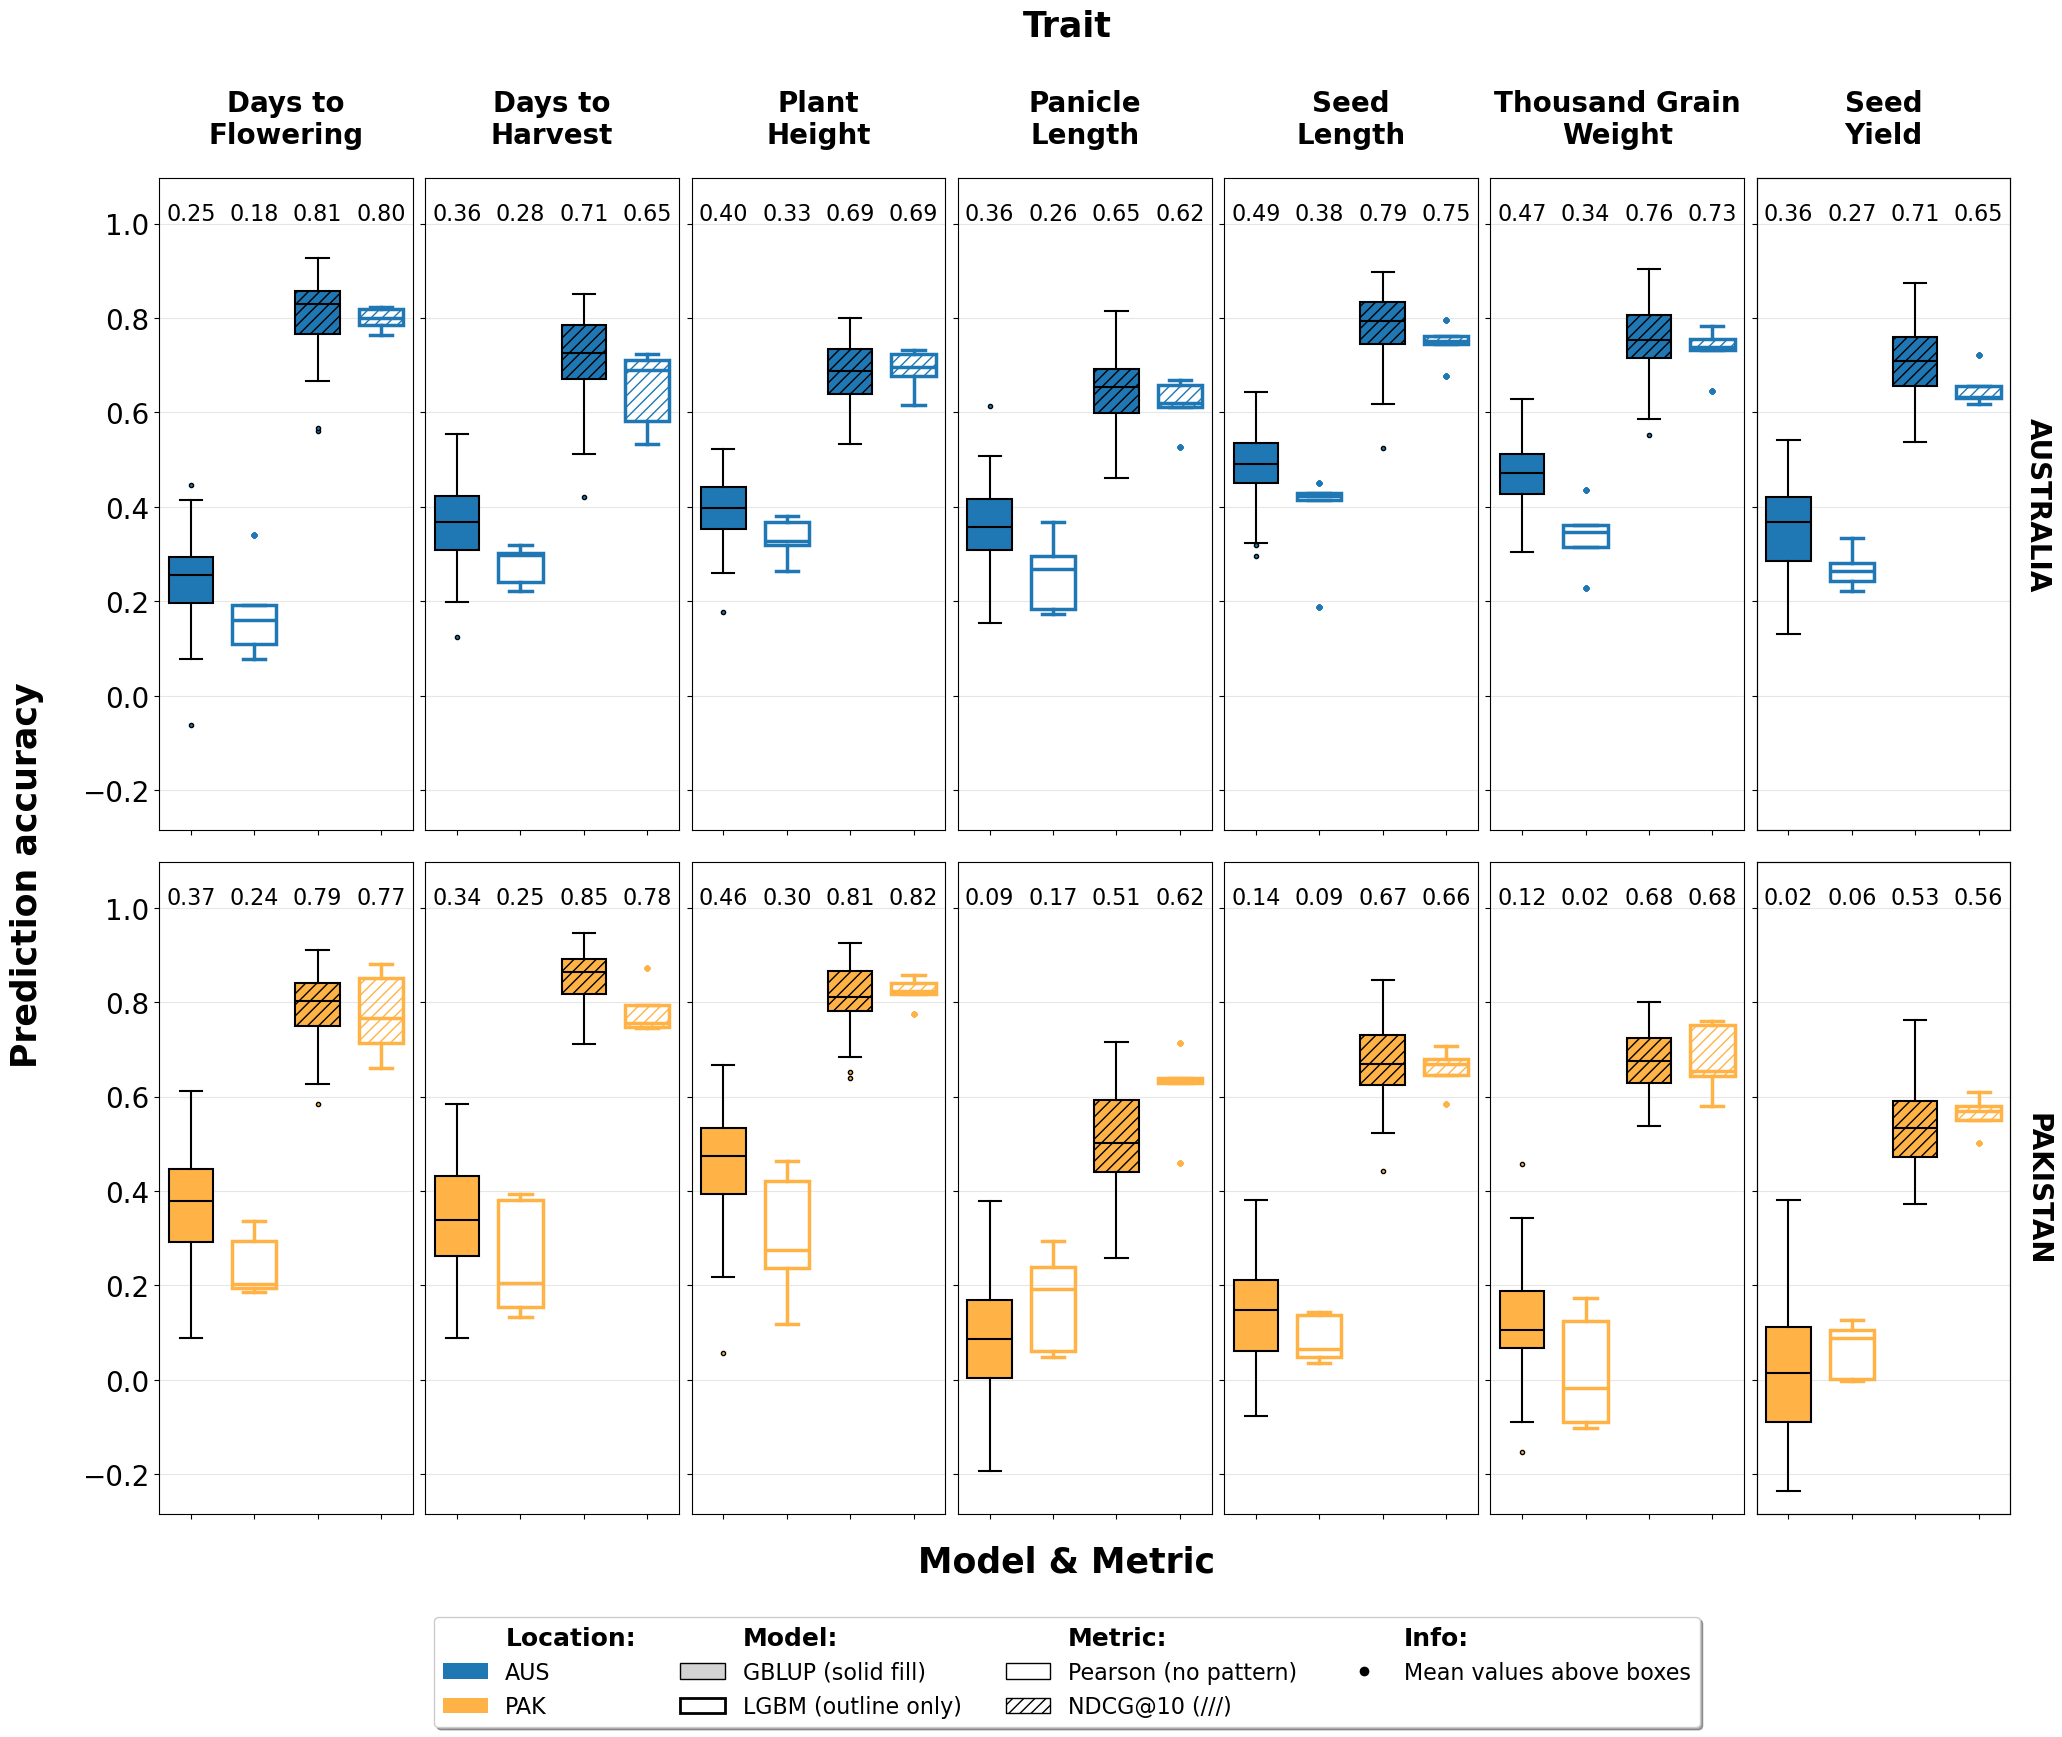

In [ ]:
## blue input type plot
# Define  trait order
trait_order = ['DTF', 'DTH', 'PtHt', 'PcleLng', 'SdLen', 'TGW', 'SdW']

# create plot
fig = plot_genomic_prediction_with_metrics(auspakgp_restructured, 
                                  trait_order=trait_order,
                                  input_type='blue')
# fig.savefig('genomic_prediction_comparison_blue_input.png', 
#              dpi=300, bbox_inches='tight')

Plotting 7 traits, 2 locations, 2 models, 2 metrics
Traits: ['DTF', 'DTH', 'PtHt', 'PcleLng', 'SdLen', 'TGW', 'SdW']
Locations: ['AUS', 'PAK']
Models: ['GBLUP', 'LGBM']
Metrics: ['ndcg_at_10', 'pearson']

Statistical Summary (Mean data):

Days to Flowering (DTF):
                            mean    std  count
model location metric                         
GBLUP AUS      ndcg_at_10  0.781  0.074     75
               pearson     0.249  0.087     75
      PAK      ndcg_at_10  0.798  0.073     75
               pearson     0.343  0.118     75
LGBM  AUS      ndcg_at_10  0.778  0.040     75
               pearson     0.188  0.096     75
      PAK      ndcg_at_10  0.785  0.101     75
               pearson     0.264  0.093     75

Days to Harvest (DTH):
                            mean    std  count
model location metric                         
GBLUP AUS      ndcg_at_10  0.712  0.088     75
               pearson     0.356  0.084     75
      PAK      ndcg_at_10  0.854  0.058     75
       

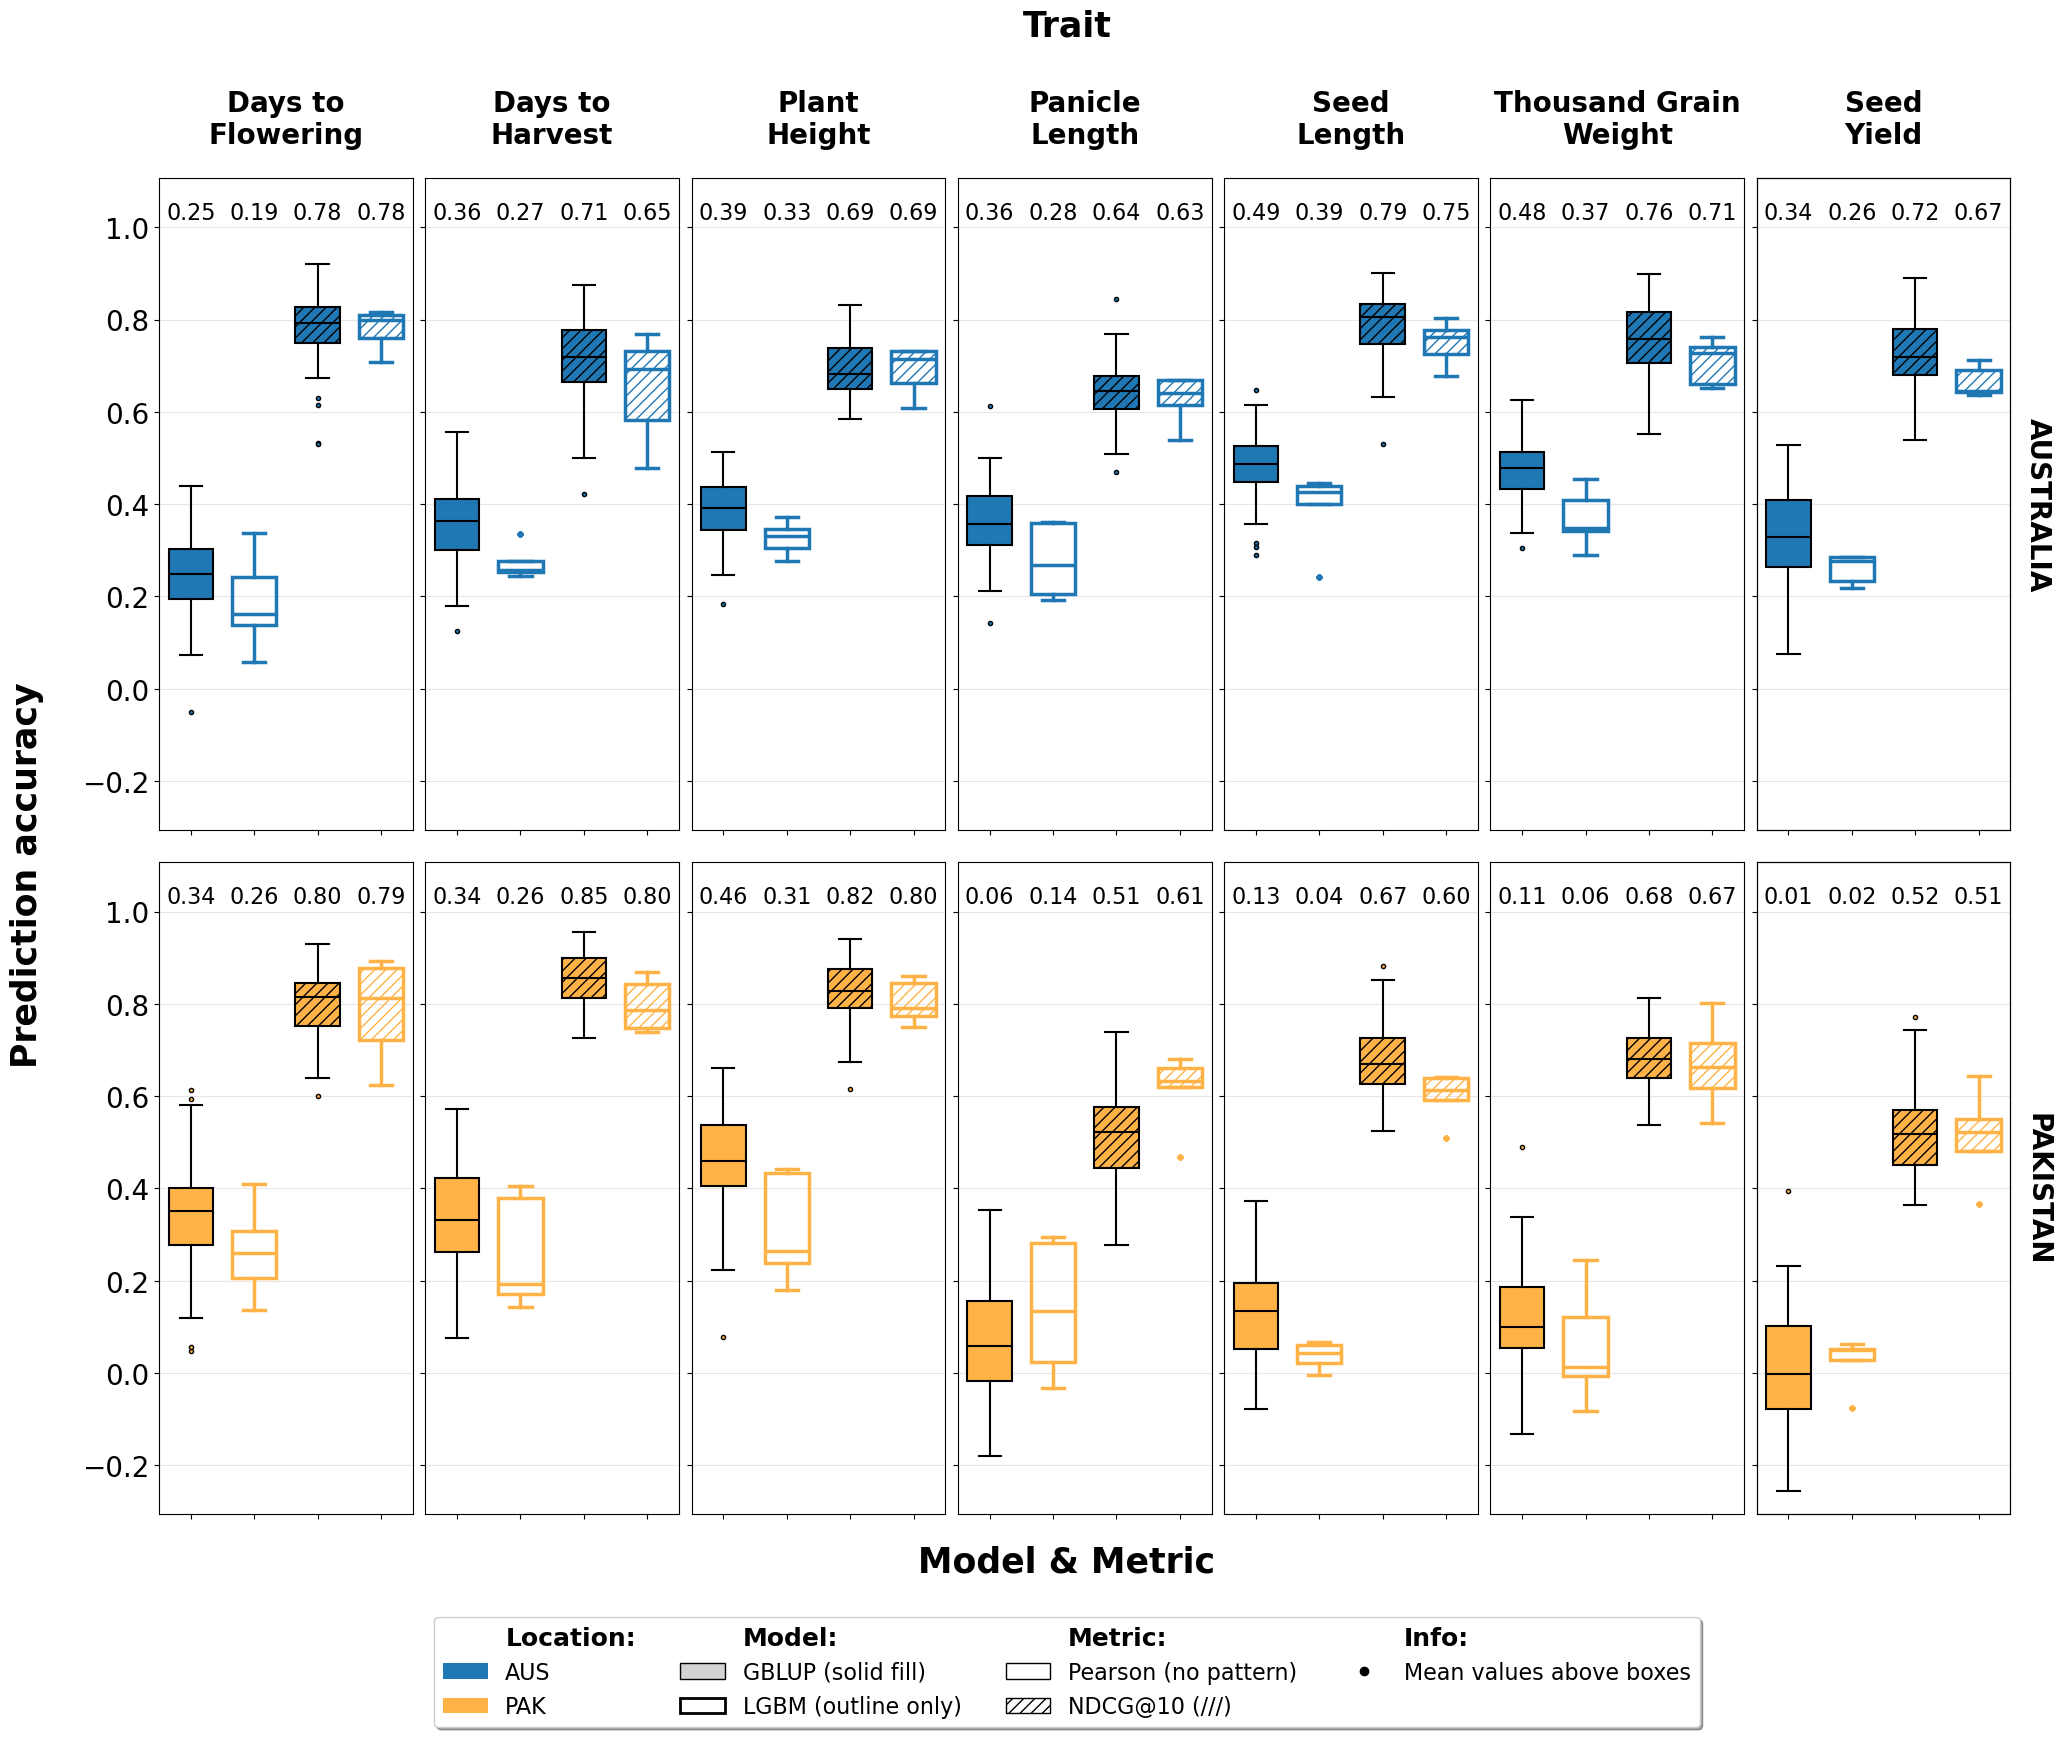

In [8]:
## mean input type plot
# Define  trait order
trait_order = ['DTF', 'DTH', 'PtHt', 'PcleLng', 'SdLen', 'TGW', 'SdW']

# create plot
fig = plot_genomic_prediction_with_metrics(auspakgp_restructured, 
                                  trait_order=trait_order,
                                  input_type='mean')


# Comparing average model performance across all traits

In [19]:
auspakblue = prepare_metric_data(auspakgp_restructured, input_type='blue')

In [21]:
auspakblue.head()

,trait,location,model,iteration,fold,seed,n_test_genotypes,input_type,metric,value
0,PcleLng,AUS,GBLUP,1,1,1001,103,blue,pearson,0.486706
1,PcleLng,PAK,GBLUP,1,1,1001,61,blue,pearson,0.205704
2,SdW,AUS,GBLUP,1,1,1001,108,blue,pearson,0.210250
3,SdW,PAK,GBLUP,1,1,1001,57,blue,pearson,0.062502
4,TGW,AUS,GBLUP,1,1,1001,101,blue,pearson,0.464210


In [32]:
summary = auspakblue.groupby(['location', 'model', 'metric'])['value'].agg(['mean']).round(2)

In [33]:
summary

mean
location model metric          
AUS      GBLUP ndcg_at_10  0.73
               pearson     0.38
         LGBM  ndcg_at_10  0.70
               pearson     0.29
PAK      GBLUP ndcg_at_10  0.69
               pearson     0.22
         LGBM  ndcg_at_10  0.70
               pearson     0.16

In [31]:
# write summary to csv

summary.to_csv('AUSPAK_genomic_prediction_summary_blue.csv')